# Techniques of High-Performance Computing Project Stage 2: Demonstration Code

Parabolic equation: 
$$u_t = \nabla \cdot \left(\sigma(x, y)\nabla\right)u$$

Space Domain: $(x, y)\in [0, 1]\times [0, 1]$ 

Initial conditions: $u(x, y, 0) = g(x, y)$ at time $t=0$ and $u(x, y, t) = 0$ on the boundary for all $t\geq 0$ 

Forward difference scheme for time discretisation: 
$$u_t(x, y)\approx \frac{u(x, y, t+\Delta t) - u(x, y, t)}{\Delta t}$$

In [1]:
# OpenCL
import pyopencl as cl

# Mathematical functions
import numpy as np

# Performance measurement 
from time import time

# Plotting 
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

# Initial Conditions and Time Discretisation

In [2]:
# Size of matrix
N = 20

# Generate xy grid
xpoints, ypoints = np.mgrid[0 : 1: 1j * N, 0 : 1: 1j * N]

# Initial conditions g
g = np.zeros((N - 2, N - 2))
g[int(N/2)-3:int(N/2)+1, int(N/2)-3:int(N/2)+1] = np.ones((4, 4))
g = g.reshape((N - 2) ** 2)

# Apply initial conditons to u
u = g
 
# Generate random sigma function with seed
random = np.random.RandomState(0) 
sigma = np.exp(random.rand(N ** 2, ))

# Number of time steps
number_of_timesteps = 10

# Size of time step
dt = 10e-5

## OpenCL Implementation of the Forward Time Difference Scheme

In [3]:
ctx = cl.create_some_context()
queue = cl.CommandQueue(ctx)
mf = cl.mem_flags

kernel = """

__kernel void forward_difference(__global double *u,
                                 __global double *sigma,
                                 __global double *result,
                                 const double dt,
                                 const int N)

{

    // Global ID
    int g = get_global_id(0);

    int s_i = (g / N) + 1;
    int s_j = (g % N) + 1;
    
    // Central sigma 
    int s_central = s_i * (N + 2) + s_j;
      
    // Sigma one half approximations 
    double sigma_i_plus = 0.5 * (sigma[s_central + N + 2] + sigma[s_central]);
    double sigma_i_minus = 0.5 * (sigma[s_central - N - 2] + sigma[s_central]);
    double sigma_j_plus = 0.5 * (sigma[s_central + 1] + sigma[s_central]);
    double sigma_j_minus = 0.5 * (sigma[s_central - 1] + sigma[s_central]);  
    
    // Nested (else) if statements for boundary checking

    // Check for first row
    if (g < N) {

        // First point
        if (g == 0) {

            // (N + 2) * (N + 2) is the prefactor 
            // Equivalent to dividing by h ** 2
            
            result[g] = ((N + 2) * (N + 2) * (sigma_i_plus * (u[g + N] - u[g]) 
                                              - sigma_i_minus * u[g] 
                                              + sigma_j_plus * (u[g + 1] - u[g]) 
                                              - sigma_j_minus * u[g])) * dt + u[g];

        }

        // Last point
        else if (g == N - 1) {

            result[g] = ((N + 2) * (N + 2) * (sigma_i_plus * (u[g + N] - u[g]) 
                                              - sigma_i_minus * (u[g]) 
                                              + sigma_j_plus * (-u[g]) 
                                              - sigma_j_minus * (u[g] - u[g - 1]))) * dt + u[g];

        }

        // Points in between
        else {

             result[g] = ((N + 2) * (N + 2) * (sigma_i_plus * (u[g + N] - u[g]) 
                                               - sigma_i_minus * (u[g]) 
                                               + sigma_j_plus * (u[g + 1] - u[g]) 
                                               - sigma_j_minus * (u[g] - u[g - 1]))) * dt + u[g];

        }

    }

    // Check for last row
    else if (g > N * (N - 1) - 1) {

        // First point
        if (g == N * (N - 1)) {

            result[g] = ((N + 2) * (N + 2) * (sigma_i_plus * (- u[g]) 
                                              - sigma_i_minus * (u[g] - u[g - N]) 
                                              + sigma_j_plus * (u[g + 1] - u[g]) 
                                              - sigma_j_minus * u[g])) * dt + u[g];

        }
        
        // Last point
        else if (g == N * (N - 1) - 1 + N) {

            result[g] = ((N + 2) * (N + 2) * (sigma_i_plus * (- u[g]) 
                                              - sigma_i_minus * (u[g] - u[g - N]) 
                                              + sigma_j_plus * (- u[g]) 
                                              - sigma_j_minus * (u[g] - u[g - 1]))) * dt + u[g];

        }

        // Points in between
        else {

            result[g] = ((N + 2) * (N + 2) * (sigma_i_plus * (- u[g]) 
                                              - sigma_i_minus * (u[g] - u[g - N]) 
                                              + sigma_j_plus * (u[g + 1] - u[g]) 
                                              - sigma_j_minus * (u[g] - u[g - 1]))) * dt + u[g];

        }

    }

    // Check for first column
    else if (g % N == 0) {

        result[g] = ((N + 2) * (N + 2) * (sigma_i_plus * (u[g + N] - u[g]) 
                                          - sigma_i_minus * (u[g] - u[g - N]) 
                                          + sigma_j_plus * (u[g + 1] - u[g]) 
                                          - sigma_j_minus * (u[g]))) * dt + u[g];

    }

    // Check for last column
    else if ((g + 1) % N == 0) {

        result[g] = ((N + 2) * (N + 2) * (sigma_i_plus * (u[g + N] - u[g]) 
                                          - sigma_i_minus * (u[g] - u[g - N]) 
                                          + sigma_j_plus * (- u[g]) 
                                          - sigma_j_minus * (u[g] - u[g - 1]))) * dt + u[g];

    }

    // All others
    else {

        result[g] = ((N + 2) * (N + 2) * (sigma_i_plus * (u[g + N] - u[g]) 
                                          - sigma_i_minus * (u[g] - u[g - N]) 
                                          + sigma_j_plus * (u[g + 1] - u[g]) 
                                          - sigma_j_minus * (u[g] - u[g - 1]))) * dt + u[g];

    }
 

}
   

""" 

# Other variables (sigma, etc.) are read as "global variables" defined earlier 
def solveParabolicDiffusion(u):

    # Local variable N
    N = np.int32(np.sqrt(u.shape[0]))
    
    # Set up buffers
    u_buffer = cl.Buffer(ctx, mf.COPY_HOST_PTR | mf.READ_ONLY, hostbuf=u)
    sigma_buffer = cl.Buffer(ctx, mf.COPY_HOST_PTR | mf.READ_ONLY, hostbuf=sigma)
    result_buffer = cl.Buffer(ctx, mf.ALLOC_HOST_PTR, size=u.shape[0] * 8)

    prg = cl.Program(ctx, kernel)
    prg.build()
    u_kernel = prg.forward_difference

    u_kernel(queue, (u.shape[0], ), (1, ), 
             u_buffer, sigma_buffer, result_buffer, np.float64(dt), np.int32(N))

    result, _ = cl.enqueue_map_buffer(queue, result_buffer, cl.map_flags.READ, 
                                      0, (u.shape[0], ), np.double)

    queue.finish()

    return np.array(result)

# Measuring Performance

In [4]:
# Measure time taken to perform specified number of time steps 
start_time = time()
for t_index in range(1, number_of_timesteps + 1):
    # Recursive relation
    u = solveParabolicDiffusion(u)
end_time = time()
print("Elapsed time (s): {0}".format(end_time - start_time))

Elapsed time (s): 0.09660935401916504


# Boundary Conditions

In [5]:
# Initialise array of zeros
# "_b" indicates with boundaries added in
g_b = np.zeros((N, N))
u_b = np.zeros((N, N))

# Embed interior with OpenCL result 
g_b[1:N-1, 1:N-1] = g.reshape(N - 2, N - 2)
u_b[1:N-1, 1:N-1] = u.reshape(N - 2, N - 2)

# Top-Down View

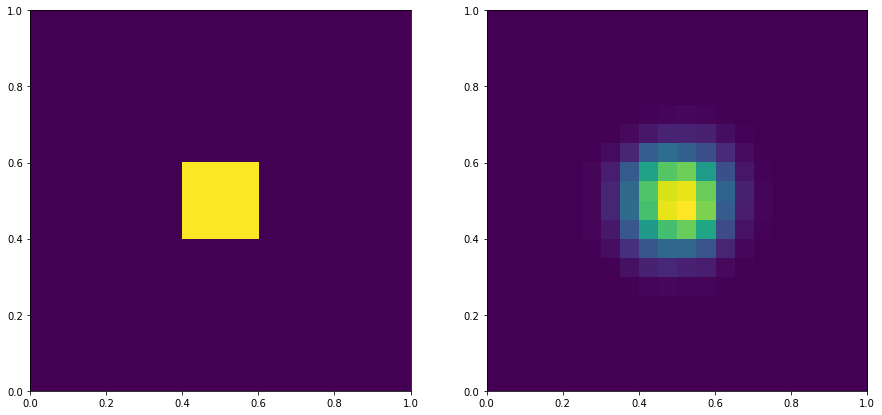

In [6]:
# Set up figures 
figure = plt.figure(figsize=(15, 15))
ax1 = figure.add_subplot(121)
ax2 = figure.add_subplot(122)

# Initial
ax1.imshow(g_b.reshape(N, N), extent=[0, 1, 0, 1], origin='lower')
ax1.set_aspect('equal')

# 10 time steps after
ax2.imshow(u_b.reshape(N, N), extent=[0, 1, 0, 1], origin='lower')
ax2.set_aspect('equal')

# 3D Scatter Plots

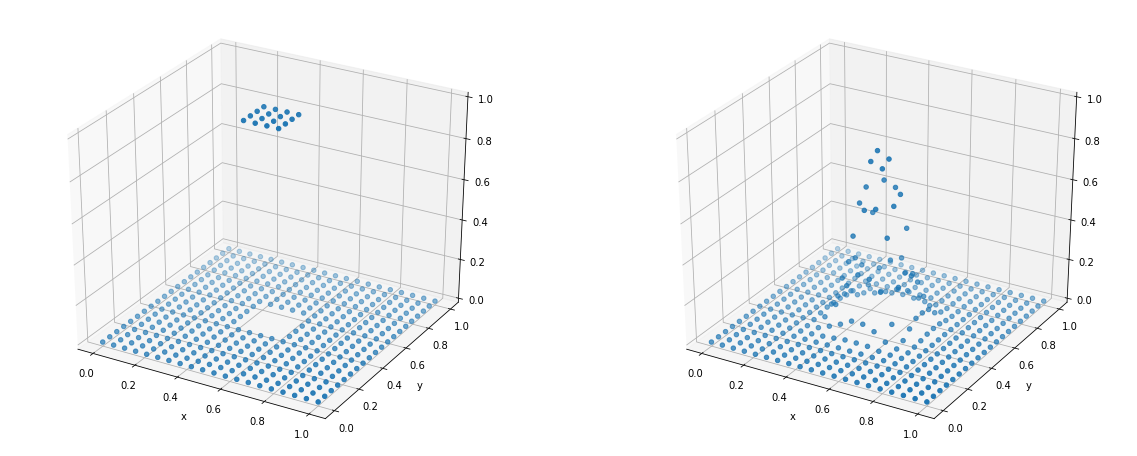

In [7]:
fig = plt.figure(figsize=(20, 8))

# Initial 
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.scatter(xpoints, ypoints, g_b)
# Fix z-axis for better comparison
ax.set_zlim(0, 1)
ax.set_xlabel("x")
ax.set_ylabel("y")

# Final
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter(xpoints, ypoints, u_b)
ax.set_zlim(0, 1)
ax.set_xlabel("x")
ax.set_ylabel("y")

plt.show()

# 3D Surface Plots

Number of time steps: 10
Size of time step (s): 0.0001
Time passed (s): 0.001


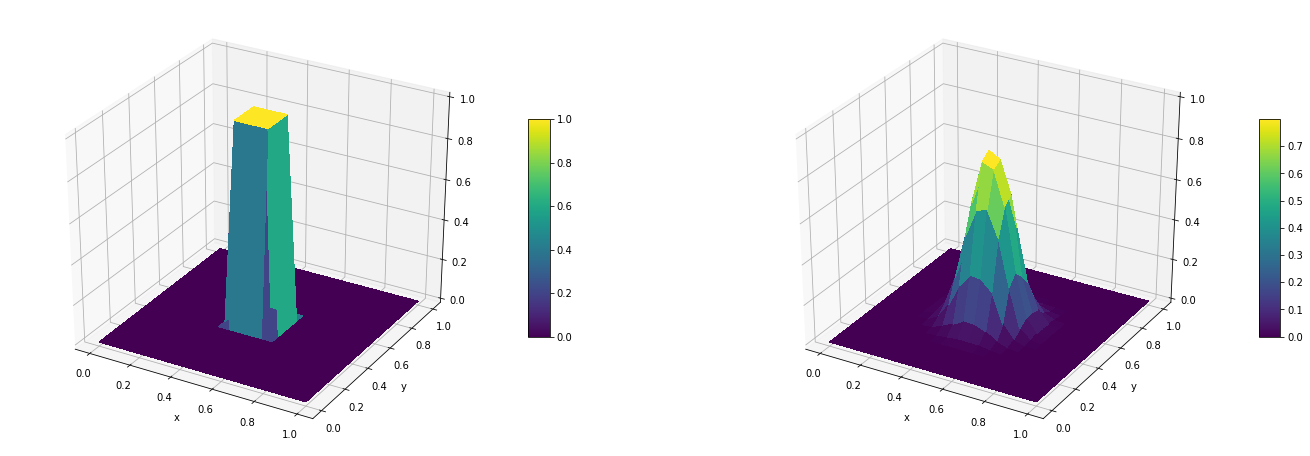

In [8]:
fig = plt.figure(figsize=(24, 8))

# Initial
ax = fig.add_subplot(1, 2, 1, projection='3d')
surf = ax.plot_surface(xpoints, ypoints, g_b.reshape(N, N), cmap=cm.viridis, linewidth=0, antialiased=False)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlim(0, 1)
fig.colorbar(surf, shrink=0.5, aspect=10)

# Final
ax = fig.add_subplot(1, 2, 2, projection='3d')
surf = ax.plot_surface(xpoints, ypoints, u_b.reshape(N, N), cmap=cm.viridis, linewidth=0, antialiased=False)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlim(0, 1)
fig.colorbar(surf, shrink=0.5, aspect=10)

# Calculate and print time details
print("Number of time steps:", number_of_timesteps)
print("Size of time step (s):", dt)
print("Time passed (s):", number_of_timesteps * dt)

plt.show()